In [1]:
!pip install mxnet-cu100

     |████████████████████████████████| 488.3MB 28kB/s 
     |████████████████████████████████| 13.8MB 29.5MB/s 
ERROR: spacy 2.1.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.52 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4


In [0]:
import logging
import numpy as np
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd

import tqdm
import zipfile
import os


# Prepare Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

data_file = 'gdrive/My Drive/Datasets/mnist+m.zip'
data_path = 'FTN_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)

with zipfile.ZipFile(data_file, 'r') as zipf:
    zipf.extractall(path=data_path)

In [5]:
!ls FTN_dataset/

mnist  mnist_m


In [0]:
MNIST_M_DIR = 'FTN_dataset/mnist_m/'
MNIST_DIR = 'FTN_dataset/mnist'

# np.mean(mnist['train_data'][mnist['train_label'] > 4])
# 0.13045387
# np.std(mnist['train_data'][mnist['train_label'] > 4])
# 0.30712798
MNIST_MEAN = 0.13
MNIST_STD = 0.31

#
MNIST_M_MEAN = [0.46, 0.46, 0.41] 
MNIST_M_STD = [0.25, 0.24, 0.26]

# Prepare MNIST_M 0-4

In [7]:
mnist_m_filenames = []
mnist_m_labels = []

with open(os.path.join(MNIST_M_DIR, 'mnist_m_train_labels.txt'), 'r') as f:
  for line in f:
    filename, label = line.split()
    if label in ['0', '1', '2', '3', '4']:
      mnist_m_filenames.append(filename)
      mnist_m_labels.append(label)
      
mnist_m = {
    'train_data' : [],
    'train_label' : []
}

for filename, label in zip(mnist_m_filenames, mnist_m_labels):
  img_path = os.path.join(MNIST_M_DIR, 'mnist_m_train', filename)
  img_arr = mx.image.imread(img_path)
  img_arr = nd.transpose(img_arr, (2, 0, 1))
  
  mnist_m['train_data'].append(img_arr.asnumpy())
  mnist_m['train_label'].append(label)
  
mnist_m_arr = np.array(mnist_m['train_data'])
mnist_m_labels_arr = np.array(mnist_m['train_label'])

print('mnist_m max = {}, min = {}'.format(mnist_m_arr.max(), 
                                          mnist_m_arr.min()))

mnist_m_arr = mnist_m_arr / mnist_m_arr.max()

mnist_m_mean = [ mnist_m_arr[:, i, :, :].mean() for i in range(3) ] 
mnist_m_std =  [ mnist_m_arr[:, i, :, :].std() for i in range(3) ] 
print('Mean = {}'.format(mnist_m_mean))
print('Std = {}'.format(mnist_m_std))

mnist_m max = 255, min = 0
Mean = [0.4568427891903558, 0.4614167053501209, 0.40715135451445683]
Std = [0.25161559921783655, 0.2362237514578506, 0.25838594334367865]


# Prepare MNIST 5-9

In [0]:
mnist = mx.test_utils.get_mnist()

In [9]:
mnist['train_data'].shape

(60000, 1, 28, 28)

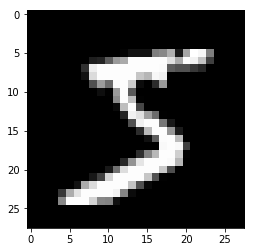

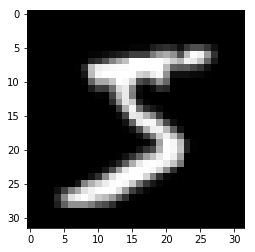

In [10]:
mnist_example = mnist['train_data'][mnist['train_label'] > 4][0][0]

plt.figure()
plt.imshow(mnist_example, cmap='gray')

mnist_example = (mnist_example - MNIST_MEAN) / MNIST_STD

mnist_example = mx.image.imresize(nd.array(mnist_example[...,np.newaxis]), 
                                  32, 32).asnumpy().squeeze()
plt.figure()
plt.imshow(mnist_example, cmap='gray');



In [11]:
# Following (Haeusser et al., 2017), we preprocess the data 
# https://github.com/haeusser/learning_by_association/blob/master/semisup/tools/data_util/create_mnistm.py
# by subtracting a channel-wise pixel mean 
# and dividing by channel-wise standard deviation of pixel values. 
# For MNIST examples, we also apply color-intensity inversion. 
# All images are resized into 32×32 with 3 channels.

# MNIST-M http://yaroslav.ganin.net/
# DANN tf example https://github.com/pumpikano/tf-dann

mnist_arr = mnist['train_data'][mnist['train_label'] > 4]
mnist_labels_arr = mnist['train_label'][mnist['train_label'] > 4]

def mnist_transform(x):
  x = (x - MNIST_MEAN) / MNIST_STD

  x = mx.image.imresize(nd.transpose(nd.array(mnist_arr[0]), (1, 2, 0)), 
                        32, 32)
  
  x = nd.tile(x, reps=(3))
  
  x = nd.transpose(x, (2, 1, 0))
  x = nd.expand_dims(x, axis=0)
  return x

mnist_transformed_list = []

for img in tqdm.tqdm(mnist_arr):
   mnist_transformed_list.append( mnist_transform(img) )

mnist_formated_arr = nd.concat(*mnist_transformed_list, dim=0)

100%|██████████| 29404/29404 [00:13<00:00, 2211.94it/s]


# PairDataIterator

In [0]:
class PairDataIter(mx.io.DataIter):
    def __init__(self, data, labels, batch_size):
        super(PairDataIter, self).__init__()
        
        self.batch_size=batch_size
        self.provide_label=[('y12', (batch_size, 1)), ]
        self.provide_data=[('x', (batch_size, 32, 32)), ('x_plus', (batch_size, 32, 32))]
        
        self.data = data
        self.labels = labels
        
#         self.pairs, self.sim_labels = self._create_pairs()
#         self.end_idx = len(self.sim_labels) // self.batch_size
        self.count = 0

    def reset(self):
        #self.count = 0
        #indexes = range(len(self.pairs))
        #random.shuffle(indexes)
        #self.pairs = self.pairs[indexes]
        #self.sim_labels = self.sim_labels[indexes]
        pass
        
    def next(self):
#         if self.count == self.end_idx:
#             raise StopIteration
        #pair_data = self.pairs[self.count*self.batch_size:(self.count+1)*self.batch_size]
        #sim_labels = self.sim_labels[self.count*self.batch_size:(self.count+1)*self.batch_size]
        #self.count += 1
        pair_data, sim_labels = self._create_pairs_batch()
        
        return mx.io.DataBatch(
            data=[mx.nd.array(pair_data[:,0]), mx.nd.array(pair_data[:,1])],
            label=[mx.nd.array(sim_labels.reshape((self.batch_size, 1)))],
            provide_data=self.provide_data,
            provide_label=self.provide_label
        )
    
    
    def _create_pairs_batch(self):
      
      pairs = []
      labels = []
      
      unique_labels = np.unique(self.labels)
      label_indices = { i : np.where(self.labels == i)[0] for i in unique_labels }
      
      idxs = np.random.choice(len(self.data), size=self.batch_size)
      
      for i in idxs:
        
        img = self.data[i]
        l = self.labels[i]
        
        l2 = np.random.choice(unique_labels)
        j = np.random.choice(label_indices[l2])
          
        x2 = self.data[j]
        pairs += [ [img, x2] ]
        labels += [ l == l2 ]
        
          
      return np.array(pairs), np.array(labels)
    
      
    def _create_pairs(self):
      
      pairs = []
      labels = []
      
      unique_labels = np.unique(self.labels)
      label_indices = { i : np.where(self.labels == i)[0] for i in unique_labels }
      
      for img, l in zip(self.data, self.labels):
        
        for i in np.random.choice(label_indices[l], size=3):
          
          x2 = self.data[i]
          pairs += [ [img, x2] ]
          labels += [ 1 ]
        
        other_labels = set(unique_labels)
        other_labels.remove(l)
        
        l2s = np.random.choice(list(other_labels), size=3)
        for l2 in l2s:
          x2 = self.data[np.random.choice(label_indices[l2])]
          pairs += [ [img, x2] ]
          labels += [ 0 ]
          
      return np.array(pairs), np.array(labels)

In [0]:
class NPairDataIter(mx.io.DataIter):
    def __init__(self, data, labels, N=5):
        super(NPairDataIter, self).__init__()
        self.N = N
        self.provide_label=[('l', (N, 1)), ] 
        self.provide_data=[('x', (N, 32, 32)), ('x_plus', (N, 32, 32))]        
        self.data = data
        self.labels = labels
        
        self.unique_labels = np.unique(self.labels)
        
        assert self.N <= len(self.unique_labels), 'number of classes is less than N'
        
        self.label_indices = { i : np.where(self.labels == i)[0] 
                              for i in self.unique_labels }
      

    def reset(self):
        pass
        
    def next(self):
        pair_data, labels = self._create_pairs_batch()
        
        return mx.io.DataBatch(
            data=[mx.nd.array(pair_data[:,0]), mx.nd.array(pair_data[:,1])],
            label=[mx.nd.array(labels.reshape((self.N, 1)))],
            provide_data=self.provide_data,
            provide_label=self.provide_label
        )
    
    
    def _create_pairs_batch(self):
      pairs = []
      labels = [] 
      sample_labels = np.random.choice(self.unique_labels, size=self.N)
      
      for l in sample_labels:
        i1, i2 = np.random.choice(self.label_indices[l], size=2)
        pairs += [ [self.data[i1], self.data[i2] ] ]
        labels += [ l ]
            
      return np.array(pairs), np.array(labels)

# Feature Transfer Network

In [0]:
# f
class FeatureGenerator(gluon.HybridBlock):
  def __init__(self, **kwargs):
    super(FeatureGenerator, self).__init__(**kwargs)
      
    with self.name_scope():
      
      self.f = nn.HybridSequential()
      
      self.f.add(
        nn.Conv2D(channels=32, kernel_size=3, strides=1, padding=1),
        nn.Activation('relu'),
        nn.Conv2D(channels=32, kernel_size=3, strides=1, padding=1),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size = 2),
        #
        nn.Conv2D(channels=64, kernel_size=3, strides=1, padding=1),
        nn.Activation('relu'),
        nn.Conv2D(channels=64, kernel_size=3, strides=1, padding=1),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size = 2),
        # 
        nn.Conv2D(channels=128, kernel_size=3, strides=1, padding=1),
        nn.Activation('relu'),
        nn.Conv2D(channels=128, kernel_size=3, strides=1, padding=1),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size = 2),
        #
        nn.Dense(128, activation='relu'),
        nn.Dense(128)        
      )
      
  def hybrid_forward(self, F, x):
    features = self.f(x)

    # normalized to have L2-norm of 2.
    norm = mx.symbol.L2Normalization(features) * 2

    return norm

# g or Tx
class FeatureTransfer(gluon.HybridBlock):
  def __init__(self, **kwargs):
    super(FeatureTransfer, self).__init__(**kwargs)
    
    with self.name_scope():
      
      self.g = nn.HybridSequential()
      
      self.g.add(
          nn.Dense(256, activation='relu'),
          nn.Dropout(0.5),
          nn.Dense(256, activation='relu'),
          nn.Dense(128)
      )
      
  def hybrid_forward(self, F, x):
    return self.g(x) + x
      
# D1 and D2 
class DomainDiscriminator(gluon.HybridBlock):
  def __init__(self, **kwargs):
    super(DomainDiscriminator, self).__init__(**kwargs)
    
    with self.name_scope():
      
      self.D = nn.HybridSequential()
      
      self.D.add(
        nn.Dense(128, activation='relu'),
        nn.Dropout(0.5),
        nn.Dense(128, activation='relu'),
        nn.Dense(1, activation='sigmoid')
      )
      
  def hybrid_forward(self, F, x):
    return self.D(x)
  
  
# h 

def dot(data, _):
    return nd.dot(data[0], data[1]), []

class hBlock(gluon.HybridBlock):
    def hybrid_forward(self, F, x1, x2):
        out, _ = F.contrib.foreach(dot, [x1, x2], [])
        return nd.sigmoid(out)
    
   

In [15]:
# ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()
ctx = mx.cpu()
ctx 

cpu(0)

In [0]:
Lvrf = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)

BATCH_SIZE = 256

# Supervised Training of $f_{ref}$

In [0]:
# source_pairdata_iter = PairDataIter(data=mnist_m_arr, labels=mnist_m_labels_arr, batch_size=BATCH_SIZE)

f_ref = FeatureGenerator()
f_ref.hybridize()
f_ref.initialize(ctx=ctx)

lr = 0.0003

trainer_f_ref = gluon.Trainer(
  params = f_ref.collect_params(),
  optimizer = 'adam',
  optimizer_params = {'learning_rate' : lr}
)

# Feature Transfer Network 

In [0]:
f = FeatureGenerator()
f.hybridize()
f.initialize(mx.init.Xavier(), ctx=ctx)

g = FeatureTransfer()
g.hybridize()
g.initialize(mx.init.Xavier(), ctx=ctx)

d1 = DomainDiscriminator()
d1.hybridize()
d1.initialize(mx.init.Xavier(), ctx=ctx)

d2 = DomainDiscriminator()
d2.hybridize()
d2.initialize(mx.init.Xavier(), ctx=ctx)


h = hBlock()

In [0]:
lr = 0.0003

trainer_f = gluon.Trainer(
  params = f.collect_params(),
  optimizer = 'adam',
  optimizer_params = {'learning_rate' : lr}
)

trainer_g = gluon.Trainer(
  params = g.collect_params(),
  optimizer = 'adam',
  optimizer_params = {'learning_rate' : lr}
)

trainer_d1 = gluon.Trainer(
  params = d1.collect_params(),
  optimizer = 'adam',
  optimizer_params = {'learning_rate' : lr}
)

trainer_d2 = gluon.Trainer(
  params = d2.collect_params(),
  optimizer = 'adam',
  optimizer_params = {'learning_rate' : lr}
)

In [0]:
def saveparams(param_dir, force=False):
  if not os.path.exists(param_dir):
    os.makedirs(param_dir)
  else:
    if not force:
      print('{} exists'.format(param_dir) )
      return
  
  f_ref.save_parameters(os.path.join(param_dir, 'f_ref.params'))
  f.save_parameters(os.path.join(param_dir, 'f.params'))
  g.save_parameters(os.path.join(param_dir, 'g.params'))
  d1.save_parameters(os.path.join(param_dir, 'd1.params'))
  d2.save_parameters(os.path.join(param_dir, 'd2.params'))
  
def loadparams(param_dir):  
  f_ref.load_parameters(os.path.join(param_dir, 'f_ref.params'))
  f.load_parameters(os.path.join(param_dir, 'f.params'))
  g.load_parameters(os.path.join(param_dir, 'g.params'))
  d1.load_parameters(os.path.join(param_dir, 'd1.params'))
  d2.load_parameters(os.path.join(param_dir, 'd2.params'))

In [0]:
 loadparams('gdrive/My Drive/Datasets/FTN_3/')

In [0]:
class NPairObjective(gluon.HybridBlock):
  def hybrid_forward(self, F, x1, x2):
#     out, _ = F.contrib.foreach(dot, [x1, x2], [])
#     return (out.exp().T / nd.dot(x1, x2.T).exp().sum(axis=1))
    return  mx.nd.diag(mx.nd.softmax(nd.dot(f1, f2.T)))

# TSNE of MNIST fs

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE


In [0]:
embeddings = f(nd.array(mnist_m_arr).as_in_context(ctx)).asnumpy()
embeddings_mnist = f(nd.array(mnist_formated_arr).as_in_context(ctx)).asnumpy()

In [25]:
print(embeddings.shape)
print(embeddings_mnist.shape)

(30092, 128)
(29404, 128)


In [26]:
embeddings

array([[-0.02641389, -0.27001867, -0.12886399, ..., -0.12996702,
        -0.09657316, -0.07133287],
       [ 0.15466644, -0.18278651, -0.07263491, ...,  0.04454231,
         0.40452617, -0.08544005],
       [-0.24408197,  0.01644863,  0.43925285, ...,  0.3943514 ,
         0.04113231, -0.0856254 ],
       ...,
       [-0.00392978, -0.1717996 ,  0.21793468, ...,  0.25012243,
         0.39012417, -0.11345775],
       [-0.25008264,  0.03829307,  0.43267107, ...,  0.39878762,
         0.05663075, -0.09756746],
       [ 0.1644276 , -0.15249464, -0.06966841, ...,  0.05600523,
         0.3813808 , -0.08887583]], dtype=float32)

In [27]:
%%time
tsne = TSNE(n_components=2,  n_iter=1000)

X_embedded = tsne.fit_transform(np.vstack([embeddings, embeddings_mnist]))

CPU times: user 20min, sys: 3.46 s, total: 20min 4s
Wall time: 20min 3s


In [28]:
type(mnist_m_labels_arr)
type(mnist_labels_arr)

numpy.ndarray

In [0]:
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(np.hstack([mnist_m_labels_arr, mnist_labels_arr])))))

In [0]:
color_map = { l : c for l, c in zip(np.unique(np.hstack([mnist_m_labels_arr, mnist_labels_arr])), colors) }

mnist_labels_colors = [ color_map[i] for i in np.hstack([mnist_m_labels_arr, mnist_labels_arr])]

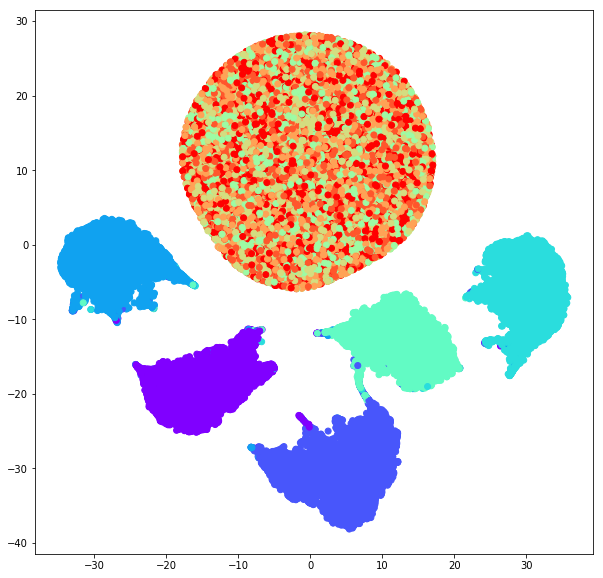

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=mnist_labels_colors)

In [31]:
import seaborn as sns
import pandas as pd

AttributeError: ignored

In [0]:
tsne_df = pd.DataFrame(data={'x1' : X_embedded[:, 0] , 'x2' : X_embedded[:, 1], 'label': np.hstack([mnist_m_labels_arr, mnist_labels_arr])})

In [0]:
sns.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'x1', 'x2')
plt.legend()